# Load Data

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'figure.figsize':(11,7), 'figure.dpi':120})
image_dest = 'results_images/'
visual_specs={'fontsize':14, 'palette':'Greys', 'saturation':0.5}
fontsize = visual_specs['fontsize']
palette = visual_specs['palette']

In [2]:
startTime = time.time()

In [3]:
#filename = '../../002_Data/Release_4/cox_PH_ready.pickle'
#filename = '../../002_Data/Release_4/cox_PH_ready_geo.pickle'
filename = '../../002_Data/Release_4/cox_time_ready.pickle'
infile = open(filename,'rb')
df = pickle.load(infile)
infile.close()
print(len(df))
df.columns.to_list()

632511


['PAST_DUE',
 'TOTAL_60_DAYS_AMT',
 'NUM_PREM_FOR_PER',
 'BREAK_ARRANGEMENT',
 'COVID_REMINDER',
 'MULTI_DWELL_SIZE',
 'SNAP_GEO',
 'NUM_PER_FOR_PREM',
 'HAS_COTENANT',
 'SPA_PER_ID',
 'CMIS_MATCH',
 'start',
 'stop']

In [4]:
df['DURATION'] = df['stop'] - df['start']
df = df.drop(['start', 'stop'], axis=1)
df.columns.to_list()

['PAST_DUE',
 'TOTAL_60_DAYS_AMT',
 'NUM_PREM_FOR_PER',
 'BREAK_ARRANGEMENT',
 'COVID_REMINDER',
 'MULTI_DWELL_SIZE',
 'SNAP_GEO',
 'NUM_PER_FOR_PREM',
 'HAS_COTENANT',
 'SPA_PER_ID',
 'CMIS_MATCH',
 'DURATION']

# Setup

In [5]:
from lifelines import CoxPHFitter
# https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html?highlight=coxphfitter 
from custom_methods import model_eval
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

model = CoxPHFitter()
event_col = 'CMIS_MATCH'
id_col = 'SPA_PER_ID'
#entry_col = 'start'
model = CoxPHFitter()
cutoffs = [0.001, 0.005, 0.01, 0.05]
scaler = None
sampler = None
#scaler = StandardScaler()
#sampler = RandomOverSampler(sampling_strategy='minority', random_state=42)

# Run Model on All Data

## Model

In [6]:
model_all = CoxPHFitter()

model_all.fit(
    df.drop(id_col, axis=1), 
    duration_col='DURATION', 
    event_col=event_col, 
    step_size=0.1,
    #formula=formula
)

model_all.print_summary()

<lifelines.CoxPHFitter: fitted with 632511 total observations, 627483 right-censored observations>
             duration col = 'DURATION'
                event col = 'CMIS_MATCH'
      baseline estimation = breslow
   number of observations = 632511
number of events observed = 5028
   partial log-likelihood = -64621.84
         time fit was run = 2021-05-28 15:25:08 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
PAST_DUE            0.19       1.21       0.00             0.18             0.20                 1.20                 1.22
TOTAL_60_DAYS_AMT   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
NUM_PREM_FOR_PER    2.51      12.29       0.06             2.38             2.63                10.85                13.92
BREAK_ARRANGEMENT   0.39       1.47       0.04             0.30             0.48                 1.35                 1.61
COVID_REMINDER      0.02       1.02       0.01             0.01             0.04                 1.01                 1.04
MULTI_DWELL_SIZE    0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
SNAP_GEO           -0.01       0.99       0.09            -0.18             0.16                 0.84                 1.17
NUM_PER_FOR_PREM   -0.05       0.95       0.02            -0.10            -0.00                 0.91                 1.00
HAS_COTENANT       -0.40       0.67       0.03            -0.46            -0.33                 0.63                 0.72

                       z      p   -log2(p)
covariate                                 
PAST_DUE           41.04 <0.005        inf
TOTAL_60_DAYS_AMT  30.43 <0.005     673.02
NUM_PREM_FOR_PER   39.45 <0.005        inf
BREAK_ARRANGEMENT   8.78 <0.005      59.11
COVID_REMINDER      2.55   0.01       6.55
MULTI_DWELL_SIZE    7.86 <0.005      47.86
SNAP_GEO           -0.11   0.92       0.13
NUM_PER_FOR_PREM   -2.15   0.03       4.99
HAS_COTENANT      -11.99 <0.005     107.70
---
Concordance = 0.74
Partial AIC = 129261.67
log-likelihood ratio test = 3340.07 on 9 df
-log2(p) of ll-ratio test = inf

## Stats

In [7]:
print(
    model_all.summary[["coef", "exp(coef)", "p", 'exp(coef) lower 95%', 'exp(coef) upper 95%']].\
    rename({'exp(coef) lower 95%':'[0.025', 'exp(coef) upper 95%':'0.975]'}, axis=1).\
    to_latex(float_format='%.3f')
)

\begin{tabular}{lrrrrr}
\toprule
{} &   coef &  exp(coef) &     p &  [0.025 &  0.975] \\
covariate         &        &            &       &         &         \\
\midrule
PAST\_DUE          &  0.189 &      1.208 & 0.000 &   1.197 &   1.219 \\
TOTAL\_60\_DAYS\_AMT &  0.001 &      1.001 & 0.000 &   1.001 &   1.001 \\
NUM\_PREM\_FOR\_PER  &  2.509 &     12.293 & 0.000 &  10.852 &  13.925 \\
BREAK\_ARRANGEMENT &  0.389 &      1.475 & 0.000 &   1.352 &   1.609 \\
COVID\_REMINDER    &  0.023 &      1.024 & 0.011 &   1.005 &   1.042 \\
MULTI\_DWELL\_SIZE  &  0.008 &      1.008 & 0.000 &   1.006 &   1.010 \\
SNAP\_GEO          & -0.009 &      0.991 & 0.915 &   0.836 &   1.175 \\
NUM\_PER\_FOR\_PREM  & -0.051 &      0.950 & 0.032 &   0.907 &   0.996 \\
HAS\_COTENANT      & -0.395 &      0.673 & 0.000 &   0.631 &   0.718 \\
\bottomrule
\end{tabular}



In [8]:
model_all.AIC_partial_

129261.67331521118

In [9]:
residuals = model_all.compute_residuals(df.drop(id_col, axis=1), kind='deviance')

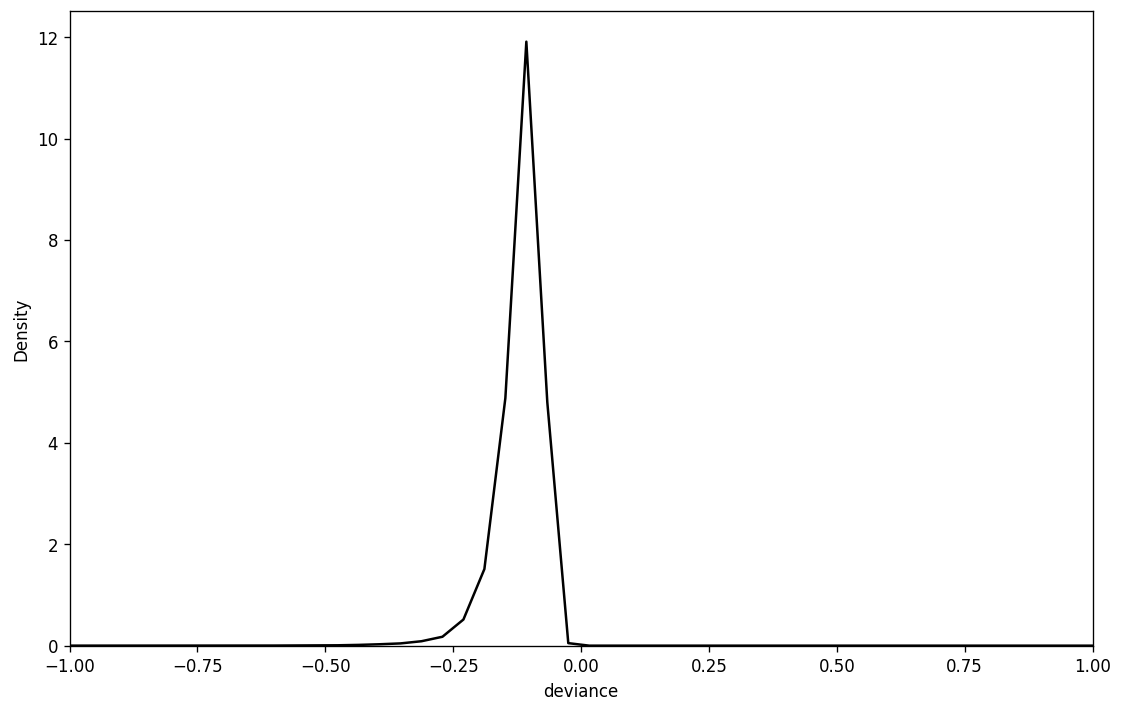

In [10]:
sns.kdeplot(x=residuals['deviance'], color='black')
bound = 1
plt.xlim((-bound, bound));
#plt.savefig(fname=image_dest+'CoxPH_resids.png')

## Plot P and N

(0.0, 0.015)

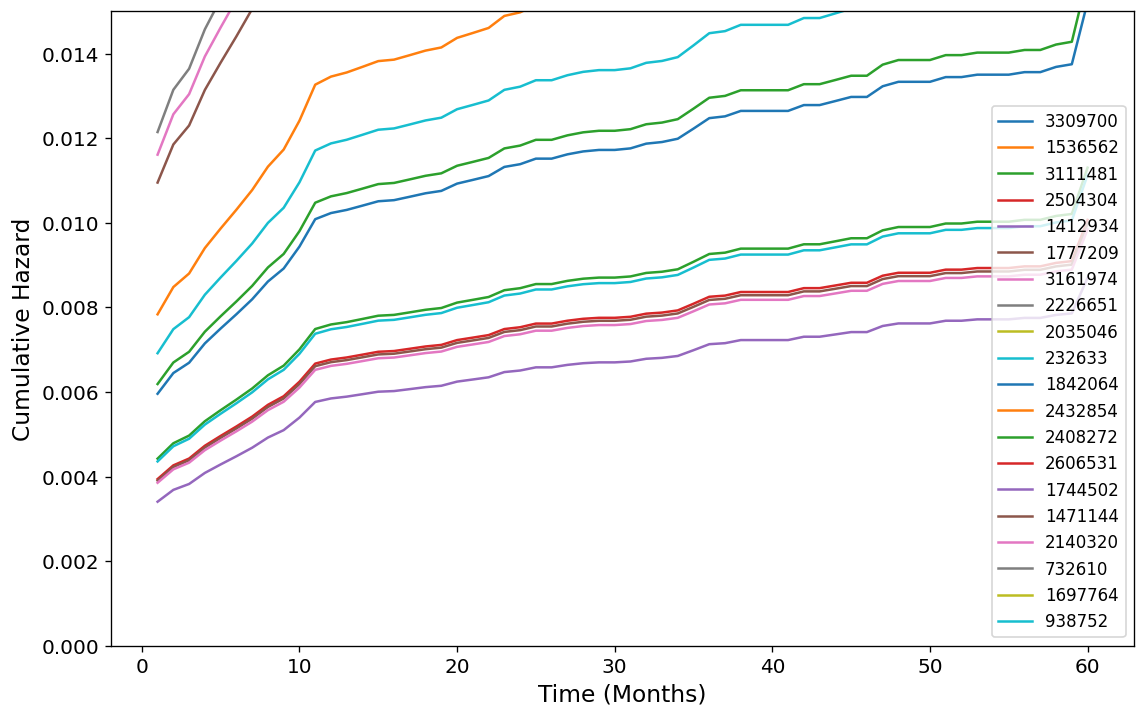

In [11]:
n = 20
ylim = (0,0.015)

pos_sample = df[df.CMIS_MATCH].sample(n)

model_all.predict_cumulative_hazard(pos_sample.drop('CMIS_MATCH', axis=1)).plot()

plt.xlabel('Time (Months)', fontsize=fontsize)
plt.xticks(fontsize=fontsize-2)
plt.ylabel('Cumulative Hazard', fontsize=fontsize)
plt.yticks(fontsize=fontsize-2)
plt.ylim(ylim)
#plt.savefig(fname=image_dest+'coxPH_hazard_P.png', bbox_inches='tight')

(0.0, 0.015)

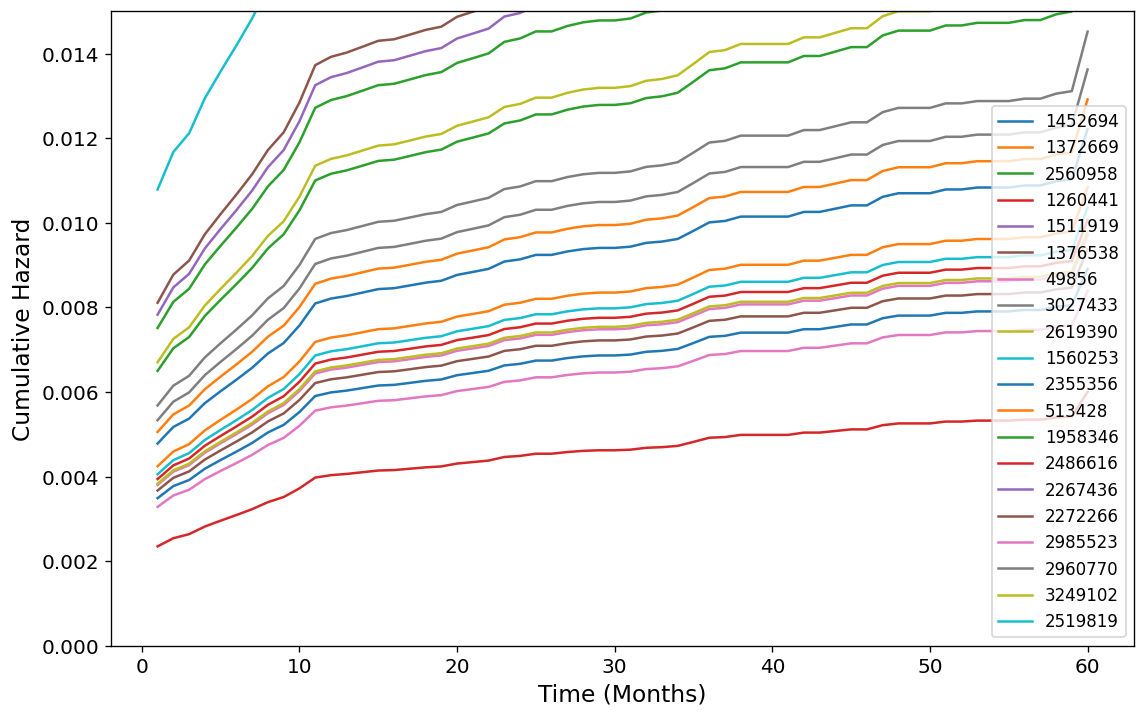

In [12]:
neg_sample = df[~df.CMIS_MATCH].sample(n)

model_all.predict_cumulative_hazard(neg_sample.drop('CMIS_MATCH', axis=1)).plot()

plt.xlabel('Time (Months)', fontsize=fontsize)
plt.xticks(fontsize=fontsize-2)
plt.ylabel('Cumulative Hazard', fontsize=fontsize)
plt.yticks(fontsize=fontsize-2)
plt.ylim(ylim)
#plt.savefig(fname=image_dest+'coxPH_hazard_N.png', bbox_inches='tight')

# K-Folds

## Run

In [13]:
predictions = model_eval.k_folds(
    df = df, 
    event_col = event_col,
    id_col = id_col, 
    k = 4, 
    model = model, 
    scaler = scaler,
    sampler = sampler
)

#predictions.head()

In [14]:

filename = '../../002_Data/Release_4/coxPH_predictions0.pickle'
outfile = open(filename, 'wb')
pickle.dump(predictions, outfile)
outfile.close()


## Summary

In [15]:
summary_recall0 = model_eval.find_recall_val(predictions, recall_threshold=0.92)
summary_recall0

,Number Predicted,Actual Number,False P/N Rate,Precision,Recall,f-1,Custom
Case,,,,,,,
Positive,482435,5028,0.761471,0.009587,0.919849,0.018976,0.464718
Negative,150076,627483,0.080151,0.997315,0.238529,0.384982,0.617922


In [16]:
summary_recall = summary_recall0.copy()

In [17]:
summary_recall['Actual Number'] = (summary_recall['Number Predicted'] * summary_recall['Precision']).astype('int')
summary_recall = summary_recall.drop('Custom', axis=1).rename(
    {'Number Predicted':'Predicted', 'Actual Number':'Hits', 'False P/N Rate':'False P/N'}, axis=1)
summary_recall.index.names = ['Class']

to_change = ['False P/N', 'Precision', 'Recall', 'f-1']
for i in to_change:
    summary_recall[i] = summary_recall[i].astype('float')

print(summary_recall.to_latex(float_format='%.2f'))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Predicted &    Hits &  False P/N &  Precision &  Recall &  f-1 \\
Class    &            &         &            &            &         &      \\
\midrule
Positive &     482435 &    4625 &       0.76 &       0.01 &    0.92 & 0.02 \\
Negative &     150076 &  149673 &       0.08 &       1.00 &    0.24 & 0.38 \\
\bottomrule
\end{tabular}



In [18]:
summary = model_eval.get_summary(predictions)
summary

Threshold_Value  Number Predicted  Actual Number  \
Max_Of    Case                                                         
Precision Positive        94.587984                13           5028   
          Negative        94.587984            632498         627483   
Recall    Positive         0.003514            632510           5028   
          Negative         0.003514                 1         627483   
f-1       Positive         8.578094              3516           5028   
          Negative         8.578094            628995         627483   
Custom    Positive         0.283934            632104           5028   
          Negative         0.283934               407         627483   

                    False P/N Rate  Precision   Recall      f-1   Custom  
Max_Of    Case                                                            
Precision Positive        0.000016   0.230769 0.000597 0.001190 0.115683  
          Negative        0.999403   0.992055 0.999984 0.996004 0.996020  
Recall    Positive        0.999998   0.007949 1.000000 0.015773 0.503975  
          Negative        0.000000   1.000000 0.000002 0.000003 0.500001  
f-1       Positive        0.005211   0.069966 0.048926 0.057584 0.059446  
          Negative        0.951074   0.992397 0.994789 0.993592 0.993593  
Custom    Positive        0.999351   0.007954 1.000000 0.015783 0.503977  
          Negative        0.000000   1.000000 0.000649 0.001296 0.500324

In [19]:
'''
TYPICAL
k, precision, f-1
2, 0.046784, 0.050363
3, 0.051020, 0.048969
3, 0.052632, 0.052676
4, 0.051282, 0.046106
4, 0.034301, 0.045788
5, 0.037634, 0.047712
'''

'\nTYPICAL\nk, precision, f-1\n2, 0.046784, 0.050363\n3, 0.051020, 0.048969\n3, 0.052632, 0.052676\n4, 0.051282, 0.046106\n4, 0.034301, 0.045788\n5, 0.037634, 0.047712\n'

In [20]:
model_eval.print_summary(summary)

\begin{tabular}{llrrrrrr}
\toprule
       &   &  Predicted &    Hits &  False P/N &  Precision &  Recall &  f-1 \\
Max\_Of & Class &            &         &            &            &         &      \\
\midrule
Precision & P &         13 &       3 &       0.00 &       0.23 &    0.00 & 0.00 \\
       & N &     632498 &  627473 &       1.00 &       0.99 &    1.00 & 1.00 \\
Recall & P &     632510 &    5028 &       1.00 &       0.01 &    1.00 & 0.02 \\
       & N &          1 &       1 &       0.00 &       1.00 &    0.00 & 0.00 \\
f-1 & P &       3516 &     246 &       0.01 &       0.07 &    0.05 & 0.06 \\
       & N &     628995 &  624213 &       0.95 &       0.99 &    0.99 & 0.99 \\
Custom & P &     632104 &    5028 &       1.00 &       0.01 &    1.00 & 0.02 \\
       & N &        407 &     407 &       0.00 &       1.00 &    0.00 & 0.00 \\
\bottomrule
\end{tabular}



# Print Time

In [21]:
from custom_methods.calc_time import calc_time_from_sec

calc_time_from_sec(time.time()-startTime)

hours:minutes:seconds = 3:24:43.336501598358154
